### Dataset by:
```
@misc{https://doi.org/10.48550/arxiv.2101.03091,
  doi = {10.48550/ARXIV.2101.03091},  
  url = {https://arxiv.org/abs/2101.03091},  
  author = {Rozemberczki, Benedek and Sarkar, Rik},  
  keywords = {Social and Information Networks (cs.SI), Artificial Intelligence (cs.AI), Machine Learning (cs.LG), FOS: Computer and information sciences, FOS: Computer and information sciences},  
  title = {Twitch Gamers: a Dataset for Evaluating Proximity Preserving and Structural Role-based Node Embeddings},  
  publisher = {arXiv},  
  year = {2021},
  copyright = {Creative Commons Attribution 4.0 International}
}

```
https://arxiv.org/abs/2101.03091

### THE TWITCH GAMERS DATASET
Twitch is a streaming service where users can broadcast live streams
of playing computer games. As users can follow each other there
is an underlying social network which can be accessed through the
public API. In 2018 April we crawled the largest connected component of this social network with snowball sampling starting from
the user called Lowko. We released Twitch Gamers dataset is a
clean subset of the original social network. We filtered out nodes
and edges based on the following principled steps:

(1) No missing attributes. We only kept nodes that have all
of the vertex attributes present.

(2) Mutual relationships. We discarded relationships which
are asymmetric and only included mutual edges in the released dataset.

(3) Member of the largest component. We only considered nodes which are part of the largest connected com-
ponent

*Quelle:* https://arxiv.org/abs/2101.03091

In [1]:
import networkx as nx   
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Netzwerk einlesen und in NetworkX abbilden

In [3]:
# Netzwerk einlesen
fh = open("data/large_twitch_edges.csv", "rb")
G = nx.read_edgelist(fh, delimiter=',')
fh.close()

In [4]:
# Remove header nodes
G.remove_node('numeric_id_1')
G.remove_node('numeric_id_2')

### Manuelle Überprüfung, ob das Netz korrekt eingelesen wurde

In [5]:
edge_list = pd.read_csv('data/large_twitch_edges.csv').astype(str)
edge_list.head()

,numeric_id_1,numeric_id_2
0,98343,141493
1,98343,58736
2,98343,140703
3,98343,151401
4,98343,157118


In [6]:
# Überprüfung, ob die Nachbarn von 98343 korrekt abgebildet wurden.
assert set(G.neighbors('98343')) == set(edge_list[edge_list.numeric_id_1=='98343'].numeric_id_2), "Neighbors of 98343 are not correctly displayed in the Network."

## EDA auf Knotenattributen und Netzwerkgrösse


### Netzwerkgrösse

In [7]:
print(f'Anzahl Knoten: {G.number_of_nodes()}')
print(f'Anzahl Kanten: {G.number_of_edges()}')
print(f'Density: {nx.density(G)}')

Anzahl Knoten: 168114
Anzahl Kanten: 6797557
Density: 0.00048103610439398153


Wir haben es also mit einem sehr grossen Netzwerk zu tun, welches aber wenig Kanten hat im Vergleich mit der Anzahl Knoten. Dies ergibt soweit Sinn, da eine Kante nur entsteht, wenn sich User gegenseitig followen. User, welche fast nur anderen zuschauen, werden wohl wenig Kanten haben, da diese eher selten gefollowed werden. Wir werden das Netzwerk nach gewissen Knotenattributen filtern, um die Prozessierung zu ermöglichen. 

Für dieses Projekt werden wir affiliate, Partner und gepartnete User als Synonym verwenden. Ebenfalls gehört jeder Channel einem User, somit kann das Wort User/Channel als fast identisch angesehen werden. Für einen Stream geht man auf Twitch "zu einem User" und nicht "einem Channel, welcher von einem User erstellt wurde". Ein Benutzer kann also nicht einen zweiten Channel erstellen mit seinem User.

Ebenfalls stimmen diese Zahlen überein mit den Zahlen, welchen uns auf der Seite gezeigt werden.

### Knotenattribute

In [8]:
features = pd.read_csv('data/large_twitch_features.csv')
features.numeric_id = features.numeric_id.astype(str)
# Cast boolean ints to booleans for more beautiful plots
for col in features.columns:
    if set([0, 1]) == set(features[col]):
        features[col] = features[col].astype(bool)

# Cast datetime cols to datetime
features.created_at = pd.to_datetime(features.created_at)
features.updated_at = pd.to_datetime(features.updated_at)

In [212]:
assert all(features.views >= 0), "Some views are negative."
# Die Daten wurden vor 2019 gesammelt.
assert all(features.created_at.dt.year <= 2019), "Some created_at are in the future."
assert all(features.updated_at.dt.year <= 2019), "Some updated_at are in the future."

In [9]:
features.sample(5)

,views,mature,life_time,created_at,updated_at,numeric_id,dead_account,language,affiliate
41339,5708,True,2509,2011-11-29,2018-10-12,41339,False,EN,True
65254,158858,False,1693,2014-02-22,2018-10-12,65254,False,EN,True
147303,29388,True,1419,2014-11-23,2018-10-12,147303,False,EN,True
52662,3956,False,874,2016-05-21,2018-10-12,52662,False,CS,False
163031,169078,False,2259,2012-08-05,2018-10-12,163031,False,EN,False


Der Datensatz hat folgende Attribute:
- `views`: Anzahl Views auf dem User / Channel
- `mature`: Ob der Channel sich an Erwachsene richtet.
- `life_time`: Anzahl Tage zwischen erstem Stream und letztem Stream.
- `created_at`: Wann der User erstellt wurde
- `updated_at`: Wann der User das letzte mal gestreamed hat.
- `numeric_id`: Unique ID des Users
- `dead_account`: Ob der Account deaktiviert wurde oder der User lange nicht aktiv war (~3 Monate)
- `language`: Sprache des Users / Channel
- `affiliate`: Ob der User ein Twitch-Partner (affiliate) ist oder nicht (nicht-Partner)

Wir können uns ein paar Attribute genauer anschauen:

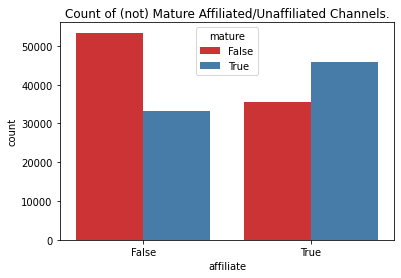

In [10]:
sns.countplot(data=features, x="affiliate", hue="mature", palette="Set1")
plt.title('Count of (not) Mature Affiliated/Unaffiliated Channels.')
plt.show()

Wir sehen also, dass mature Channels weniger oft gepartnert sind als nicht-mature Channels.

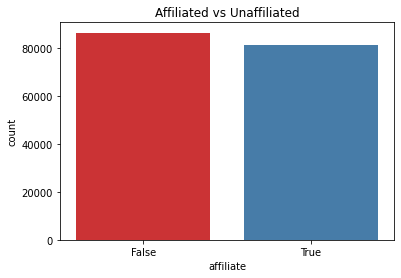

In [11]:
sns.countplot(data=features, x="affiliate", palette="Set1")
plt.title('Affiliated vs Unaffiliated')
plt.show()

Es hat überraschend viele gepartnete User mit Twitch. Ich hätte nicht gedacht, dass das Verhältniss fast 50/50 ist.

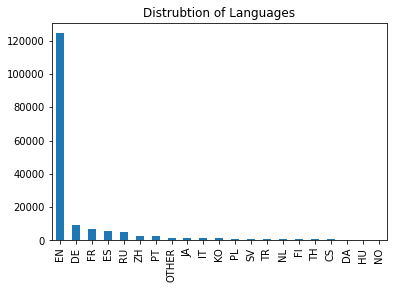

In [12]:
features.language.value_counts().plot(kind='bar', title='Distrubtion of Languages')
plt.show()

Überwiegend ist die Channelsprache Englisch, gefolgt (weit abgeschlagen) von Deutsch, Französisch, Spanisch und Russisch. 

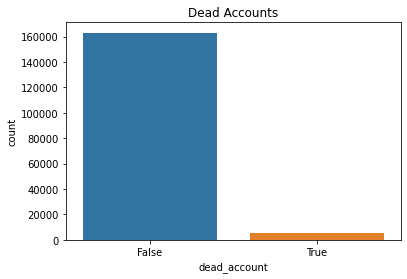

In [13]:
sns.countplot(data=features, x="dead_account")
plt.title('Dead Accounts')
plt.show()

Interessant zu sehen, dass es nur sehr wenige, inaktive User gibt. Es wäre eine Untersuchung wert, ob das vielleicht aus der Art, wie die Daten gesammelt wurden, entstanden ist (e.g., das nur aktive Accounts und ihre Follower in gescrapped wurden).

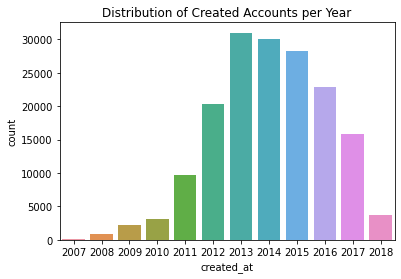

In [14]:
sns.countplot(x=features.created_at.dt.year)
plt.title('Distribution of Created Accounts per Year')
plt.show()

In diesem Plot sieht man deutlich die Jahre, wo Twitch stark zugelegt hat (2011-2016).

Im vorherigen Abschnitt haben wir die Annahme getroffen, dass Twitch-Partner mehr Kanten haben als nicht-Partner. Wir können uns dafür die Density von den zwei Subgruppen anschauen.

In [15]:
netzwerk_partner = nx.subgraph(G, features[features.affiliate==True].numeric_id.tolist())
netzwerk_kein_partner = nx.subgraph(G, features[features.affiliate==False].numeric_id.tolist())

In [16]:
print(f'Density von Nicht-Partnern: {nx.density(netzwerk_kein_partner)}')

Density von Nicht-Partnern: 0.0006154880996428399


In [17]:
print(f'Density von Partnern: {nx.density(netzwerk_partner)}')

Density von Partnern: 0.0004175468251946277


Das war nicht erwartet; Die Density von nicht-Partnern ist ca. 50% höher als von Partnern. Dies bedeutet, dass sich nicht-Partnern gegenseitiger häufiger folgen als Partner. Ändern sich diese Zahlen, wenn wir inaktive Accounts rausnehmen?

In [18]:
netzwerk_aktiv = nx.subgraph(G, features[features.dead_account==False].numeric_id.tolist())
netzwerk_aktiv_partner = nx.subgraph(netzwerk_aktiv, features[features.affiliate==True].numeric_id.tolist())
netzwerk_aktiv_kein_partner = nx.subgraph(netzwerk_aktiv, features[features.affiliate==False].numeric_id.tolist())

In [19]:
print(f'Density von aktiven Nicht-Partnern: {nx.density(netzwerk_aktiv_kein_partner)}')

Density von aktiven Nicht-Partnern: 0.0006735701234769484


In [20]:
print(f'Density von aktiven Partnern: {nx.density(netzwerk_aktiv_partner)}')

Density von aktiven Partnern: 0.00041792783234412354


Die Density nimmt zu, bei beiden, aber mehr bei den nicht-Partnern. Ergibt auch Sinn, da Partner wohl im Prinzip nicht inaktiv sein können. Dies lässt sich leicht überprüfen in einer Grafik:

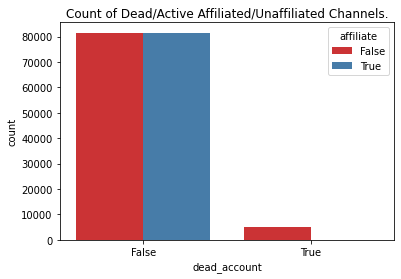

In [21]:
sns.countplot(data=features, x="dead_account", hue="affiliate", palette="Set1")
plt.title('Count of Dead/Active Affiliated/Unaffiliated Channels.')
plt.show()

Man sieht aber deutlich, dass die Anzahl von gepartnerten Accounts, welche inaktiv sind, verschwindent gering ist. Das sieht aber fast nach einem Fehler aus. Wie kann die Ratio von gepartnetern Usern von aktiven Accounts fast identisch sein? Ist da was falsch? 

In [22]:
print(f"Anteil Partner von inaktiven vs aktiven User:\n{features.groupby('dead_account')['affiliate'].value_counts()}")

Anteil Partner von inaktiven vs aktiven User:
dead_account  affiliate
False         False        81483
              True         81472
True          False         5085
              True            74
Name: affiliate, dtype: int64


Nein, die zwei Zahlen sind fast identisch. Es ist aber trotzdem unerwartet, dass sich nicht-Partner gegenseitig häufiger folgen als Partner.

#### Views
Wir schauen uns nun das Attribut `views` an von aktiven Accounts, separat für Partner und nicht-Partner.

In [23]:
active_accounts = features[features.dead_account==False]
views_active_no_partner = active_accounts[active_accounts.affiliate==False].views
views_active_partner = active_accounts[active_accounts.affiliate==True].views

In [24]:
# Print mean and median for views of active accounts without partner and with partner
print(f"Mean views of active accounts without partner: {views_active_no_partner.mean():.2f}")
print(f"Mean views of active accounts with partner: {views_active_partner.mean():.2f}")
print(f"Median views of active accounts without partner: {views_active_no_partner.median():.2f}")
print(f"Median views of active accounts with partner: {views_active_partner.median():.2f}")

Mean views of active accounts without partner: 364752.97
Mean views of active accounts with partner: 23299.74
Median views of active accounts without partner: 1945.00
Median views of active accounts with partner: 7469.00


Sehr interessant! Wieder unerwartet. Im Durchschnitt hat ein Partner ca. 15x mehr Views als nicht-Partner. Wenn wir uns aber den Median anschauen, ist das Bild anders; hier hat ein Partner ca. 4x soviele Views. Es scheint so, als hätten nicht-Partner massive Aussreisser in den Views. Dies können wir mit einem Boxplot bestätigen:

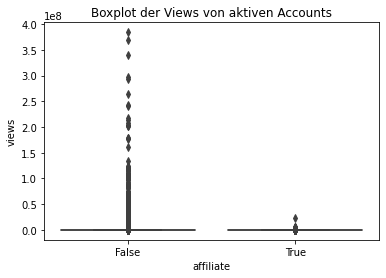

In [25]:
sns.boxplot(x='affiliate', y='views', data=active_accounts)
plt.title('Boxplot der Views von aktiven Accounts')
plt.show()

Wir können uns noch die Top 30 anschauen und sehen, dass von den Top 30 Views niemand gepartnert ist mit Twitch.

In [26]:
active_accounts.sort_values(by='views', ascending=False).head(30)

,views,mature,life_time,created_at,updated_at,numeric_id,dead_account,language,affiliate
96473,384396587,False,2416,2012-03-01,2018-10-12,96473,False,RU,False
129896,368912220,False,2379,2012-04-07,2018-10-12,129896,False,EN,False
61862,340602050,False,2826,2011-01-16,2018-10-12,61862,False,EN,False
128864,297117159,False,2314,2012-06-11,2018-10-12,128864,False,EN,False
144643,294116493,False,2577,2011-09-22,2018-10-12,144643,False,EN,False
110345,264643346,False,2664,2011-06-27,2018-10-12,110345,False,EN,False
125642,243451177,False,2507,2011-12-01,2018-10-12,125642,False,EN,False
64605,240718261,True,2516,2011-11-22,2018-10-12,64605,False,EN,False
71050,218559516,False,2169,2012-11-03,2018-10-12,71050,False,EN,False
161362,213931993,False,2359,2012-04-27,2018-10-12,161362,False,EN,False


Eine gute Erklärung habe ich dafür nicht, es wäre aber Möglich, über das Datum der Usererstellung ein Mapping zu machen zwischen der uniquen ID und dem richtigen Namen und dann mehr herausfinden zu können, warum die Channels mit den meisten User von nicht-Partnern sind.

Beispiel [Tyler1](https://twitchtracker.com/loltyler1):

- Tyler1 hat seinen User am 14.11.2013 erstellt.
- Er spricht Englisch.
- Er hatte Ende 2018 mehr als 80 Millionen Views.


Wir können nun nach diesem User filtern:

In [27]:
active_accounts[
    (active_accounts.created_at=='2013-11-14') &
    (active_accounts.language=='EN') &
    (active_accounts.views > 80000000)
    ]

,views,mature,life_time,created_at,updated_at,numeric_id,dead_account,language,affiliate
6250,84804681,True,1793,2013-11-14,2018-10-12,6250,False,EN,False


Somit entspricht die `numeric_id` 6250 wohl Tyler1. Gewisse Sachen haben sich aber geändert: Jetzt ist der Channel von Tyler1 nicht mehr an Erwachsene gerichtet. Ebenfalls war er Ende 2018 nicht Partner. Ich kann mich aber erinnern, dass Tyler1 [gebannt](https://web.archive.org/web/20190417084311/https://support.riotgames.com/hc/en-us/articles/115013815928-Understanding-ID-Bans) wurde in diesem Zeitrahmen (~2017/18) und danach wurde sein Account wieder freigeschaltet, hat aber wahrscheinlich seinen Partner-Status verloren. 

Warum die meistgesehenen Channels aber nicht gepartnert sind, bleibt eine offene Frage. 

#### 0 ist 1 und 1 ist 0 beim Attribut `Affiliated`?

Hier lässt sich aber auch die Annahme treffen, dass in den Daten ein Fehler passiert ist und beim Knotenatttribut `affiliated` 1 und 0 verwechselt wurde. Es ist sehr unwahrscheinlich, dass keiner der Top 30 meistgesehenen User mit Twitch gepartnert ist. Ggf. muss man also gewisse Analysen im EDA-Teil weiter oben anders interpretieren. Die Daten sind von 2018, aber momentan ist `Ninja` und `Tyler1` gepartnert mit Twitch. Somit lässt sich diese Annahme bestätigen, dass `affiliated` falsch herum gelabelt wurde. 

Falls wir also mehr mit dem Attribut `affiliated` machen würden, müssten wir uns fragen, ob diese Daten für das geeignet sind oder uns 100% sicher sein, dass das Attribut `affiliated` auch wirklich so stimmt.

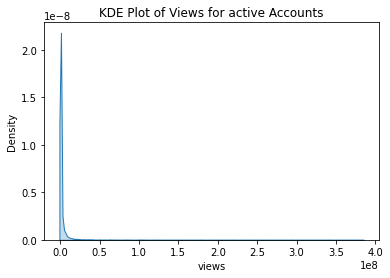

In [28]:
sns.kdeplot(active_accounts.views, shade=True)
plt.title('KDE Plot of Views for active Accounts')
plt.show()

In [29]:
# Quantiles
active_accounts.views.quantile([0.25, 0.5, 0.75, 0.99])

0.25       1515.00
0.50       4336.00
0.75      14848.50
0.99    2676764.08
Name: views, dtype: float64

Wir sehen, dass die meiste Density von Views in einem KDEPlot für alle aktiven Accounts in einem sehr kleinen Bereich liegt. 25% der User haben weniger als 1515 Views auf ihrem Channel und 50% weniger als 4336. Wir sehen auch, dass wir gegen oben (>99 Perzentil) es unglaubliche Ausreisser gibt, welche unseren Density Plot verziehen.

c:\Users\vince\anaconda3\envs\SAN\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


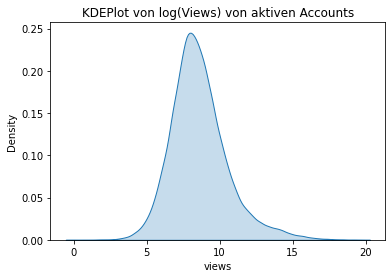

In [30]:
sns.kdeplot(np.log(active_accounts.views), shade=True)
plt.title('KDEPlot von log(Views) von aktiven Accounts')
plt.show()

c:\Users\vince\anaconda3\envs\SAN\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


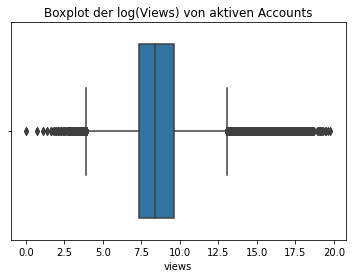

In [31]:
sns.boxplot(x=np.log(active_accounts.views))
plt.title('Boxplot der log(Views) von aktiven Accounts')
plt.show()

c:\Users\vince\anaconda3\envs\SAN\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


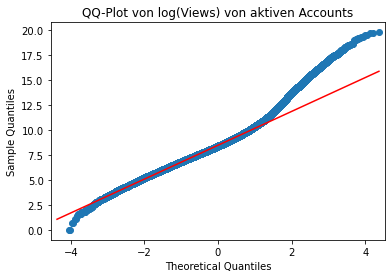

In [32]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

fig = sm.qqplot(np.log(active_accounts.views), line='q')
plt.title('QQ-Plot von log(Views) von aktiven Accounts')
plt.show()

Die Verteilung der Views scheint eine `lognorm`-Verteilung zu sein, mit massiven Aussreissern gegen oben hin (long-tail gegen rechts). Dies sehen wir auch im QQ-Plot von `log(views)`. 

### Degree Centrality

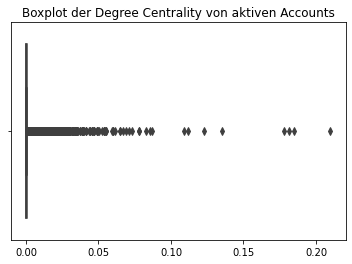

In [33]:
# Degree Centrality
degree_centrality = nx.degree_centrality(G)
sns.boxplot(x=list(degree_centrality.values()))
plt.title('Boxplot der Degree Centrality von aktiven Accounts')
plt.show()

In [34]:
np.quantile(list(degree_centrality.values()), [0.90, 0.9999])

array([0.00096364, 0.06533704])

Die Degree Centrality zeigt, dass 90% der User mit weniger als 0.0000096% mit anderen User verbunden sind durch gegenseitiges followen. Man sieht aber auch, dass ein User mit mehr als 20% aller User verbunden ist. 

In [35]:
# Find the top 10 nodes with the highest degree centrality
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
sorted_degree_centrality[:1]

[('61862', 0.2098528965636209)]

Wir können schauen, wer das sein könnte.

In [36]:
features[features.numeric_id=='61862']

,views,mature,life_time,created_at,updated_at,numeric_id,dead_account,language,affiliate
61862,340602050,False,2826,2011-01-16,2018-10-12,61862,False,EN,False


[Ninja](https://twitchtracker.com/ninja) hat seinen Account am 16.1.2011 erstellt und er ist einer der meistgeschauten Streamer auf Twitch. Man kann also annehmen, dass er `61862` ist.

In [37]:
# Get number of neighbor for Ninja (most connected node)
for node, degree in sorted_degree_centrality[:1]:
    print(f'Node: {node}, Degree: {degree}')
    # Number of neighbor
    print(f'Number of neighbors: {G.degree(node)}')

Node: 61862, Degree: 0.2098528965636209
Number of neighbors: 35279


Dies ist schon erstaunlich. Kann dies wirklich sein, dass Ninja 20% der User auf Twitch folgt (35279 User)? Vielleicht bedeutet `mutual relationship` etwas anderes? Zitat aus dem Paper von Twitch Gamers:
```
Mutual relationships. We discarded relationships which
are asymmetric and only included mutual edges in the re-
leased dataset.
```
Ich bin mir unsicher. Es kann ja nicht sein, dass `Ninja` 20% der User auf Twitch folgt. 

Andererseits schauen wir uns in diesem Datensatz ja nicht ganz Twitch an, sondern nur ein Subset. Auf [TwitchTracker](https://twitchtracker.com/statistics) sehen wir, dass es in 2018 im Schnitt 1.08 Millionen Zuschauer gab. Somit schauen wir uns mit 168'114 Knoten auch nur einen Bruchteil von Twitch an. 

In [38]:
# Get number of neighbor for nodes with the least degree centrality
for node, degree in sorted_degree_centrality[-5:]:
    print(f'Node: {node}, Degree: {degree}')
    # Number of neighbor
    print(f'Number of neighbors: {G.degree(node)}')

Node: 131422, Degree: 5.948379958718243e-06
Number of neighbors: 1
Node: 102494, Degree: 5.948379958718243e-06
Number of neighbors: 1
Node: 157597, Degree: 5.948379958718243e-06
Number of neighbors: 1
Node: 128281, Degree: 5.948379958718243e-06
Number of neighbors: 1
Node: 118034, Degree: 5.948379958718243e-06
Number of neighbors: 1


Somit haben wir in unserem Datensatz nur User mit:
- mindestens einer Kante (gegenseitiges folgen).
- sind vom User `lowko` über ein Schneeball-System erreichbar.

Es kann also wirklich sein, dass `Ninja` 20% von diesem Subset folgt.

### Degrees

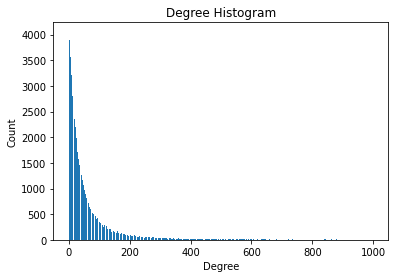

In [39]:
degree = nx.degree_histogram(G)[:1000]
plt.bar(x=range(len(degree)), height=degree)
plt.title('Degree Histogram')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.show()

Die Verteilung der Anzahl der Degrees sieht sehr exponential aus.

### Korrelation Degree und Views
Hat ein User mit vielen Kanten mehr Views?

In [40]:
id_degree_df = pd.DataFrame(G.degree(), columns=['numeric_id', 'degree'])
id_degree_df.head(5)

,numeric_id,degree
0,98343,39
1,141493,4456
2,58736,420
3,140703,242
4,151401,235


In [41]:
try:
    features.drop(columns=['degree_x', 'degree_y'], inplace=True)
    features = pd.merge(features, id_degree_df, on='numeric_id')
except:
    features = pd.merge(features, id_degree_df, on='numeric_id')

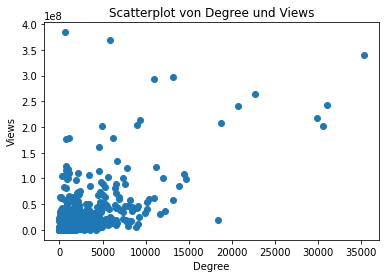

In [42]:
plt.scatter(features['degree'], features['views'])
plt.xlabel('Degree')
plt.ylabel('Views')
plt.title('Scatterplot von Degree und Views')
plt.show()

In [43]:
p_corr = np.corrcoef(features.views, features.degree)[1,0]
print(f'Pearson Korrelation von degree und views: {p_corr:.3f}')

Pearson Korrelation von degree und views: 0.650


In [44]:
from scipy.stats import spearmanr
print(f'Spearman Korrelation von degree und views: {spearmanr(features.views, features.degree)[0]:.3f}')

Spearman Korrelation von degree und views: 0.514


Wieder etwas interessantes gelernt. Laut [StackExchange](https://stats.stackexchange.com/questions/27127/what-does-it-indicate-when-the-spearman-correlation-is-a-definite-amount-less-th) ist die Spearman Korrelation niedriger als die Pearson Korrelation, falls die Rank-Korrelation niedriger ist als die Lineare-Korrelation. Das kann passieren, falls es extreme Ausreisser gibt / einen langen Longtail. Dies ist bei uns der Fall. 
#### Permutationstest
Mit einem Permutationstest können wir schauen, ob diese Pearson Korrelation nur Zufall ist. Wir wählen als `alpha` 0.05. Unsere Nullhypothese ist, dass der `degree` und die Anzahl Views nicht linear miteinander korrelieren. Die Alternativhypothese ist, dass sie miteinander korrelieren.

In [45]:
N_TESTS = 10000

p_corrs = []
corr_same_or_above = 0
for i in range(N_TESTS):
    views = features.views.sample(frac=1, replace=False, random_state=i)
    p_corrs.append(np.corrcoef(views, features.degree)[1,0])
    if p_corrs[-1] >= p_corr:
        corr_same_or_above += 1

In [46]:
print(f'p-Wert von Pearson: {corr_same_or_above/N_TESTS}')

p-Wert von Pearson: 0.0


Da der p-Wert kleiner ist als unser `alpha`, verwerfen wir die Nullhypothese und schätzen die Korrelation zwischen Knoten-Degree und Anzahl Views als signifikant ein. 

## Reichweite maximieren, Kosten minimieren
Für unsere fiktive Werbung möchten wir ein möglichst weites Publikum für möglichst kleines Geld erreichen. Es lässt sich also die Annahme treffen, dass neue Streamer mit eher wenig Degrees günstiger zu kaufen sind (sind nicht "etabliert", z.B. Freunde von grossen Streamer, welche gerade angefangen haben zu Streamen, erreichen viele Views, haben aber wenig followers) und das Streamer mit vielen Views eine grosse Reichweite haben.

Somit sollten wir folgendes optimieren:
- Degrees minimieren mit Hilfe von Knoten, welche keine oder nur wenig, gleiche Nachbarn haben, damit keine Überlappung der Views entsteht (e.g. verhindern, dass unsere Werbung von zwei gleichen Usern mehrmals gesehen wird)
- Totale Anzahl Views maximieren.

Da die lineare Korrelation mit 0.650 nicht perfekt ist, können wir einen Algorithmus dafür entwickeln, welche diese Relation optimiert.
 
Wir nehmen an, dass die Anzahl Degrees perfekt linear korreliert mit dem verlangtem Geld vom Streamer für das zeigen unserer Werbung. Somit erstellen wir eine Ratio `views per year/degree` und wollen diese möglichst hoch halten. Ebenfalls möchten wir keine Verträge mit tausenden von Streamer abschliessen und definieren eine Mindest-Anzahl `views per year`, basierend auf der maximalen Anzahl Verträge, welche wir erstellen möchten.

### Annahmen
Da wir keine `views per year` haben, teilen wir einfach die Anzahl Views durch die Anzahl Jahre seit ihrer Regristierung. Wir nehmen auch an, dass im nächsten Jahr (2019, da die Daten nur bis 2018 gehen) die Streamer genau `views per year` erreichen werden. Das entspricht nicht der Realität, aber wir haben keine besseren Daten. Ebenfalls sind wir auf den deutschen und englischen Markt fokusiert.

In [47]:
MAX_VERTRÄGE = 30
VERLANGTE_REICHWEITE_JAHR_2019 = 5*10**7 # 50 Millionen

## Dependent variables
features_optimizer = features.copy()
features_optimizer = features_optimizer[features_optimizer.language.isin(['EN', 'DE'])]
features_optimizer['registration_year'] = features_optimizer.created_at.dt.year
features_optimizer['views_per_year'] = features_optimizer.views / (2019 - features_optimizer.registration_year)
features_optimizer['views_per_year_per_degree'] = features_optimizer.views_per_year / features_optimizer.degree

In [48]:
features_optimizer.head(5)

,views,mature,life_time,created_at,updated_at,numeric_id,dead_account,language,affiliate,degree,registration_year,views_per_year,views_per_year_per_degree
0,7879,True,969,2016-02-16,2018-10-12,0,False,EN,True,43,2016,2626.333333,61.077519
1,500,False,2699,2011-05-19,2018-10-08,1,False,EN,False,278,2011,62.500000,0.224820
2,382502,True,3149,2010-02-27,2018-10-12,2,False,EN,True,122,2010,42500.222222,348.362477
3,386,False,1344,2015-01-26,2018-10-01,3,False,EN,False,11,2015,96.500000,8.772727
4,2486,False,1784,2013-11-22,2018-10-11,4,False,EN,False,33,2013,414.333333,12.555556


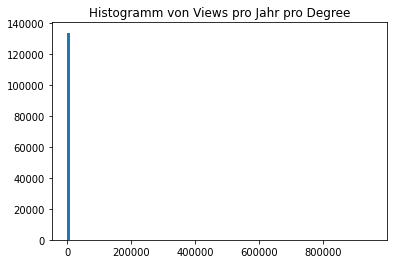

In [49]:
plt.hist(features_optimizer.views_per_year_per_degree, bins=100)
plt.title('Histogramm von Views pro Jahr pro Degree')
plt.show()
# Maybe improve?

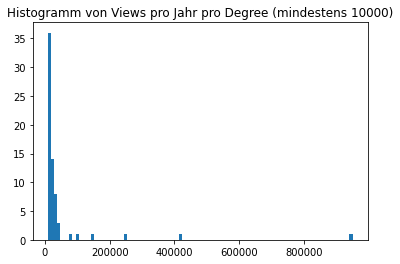

In [50]:
plt.hist(features_optimizer[features_optimizer.views_per_year_per_degree>10000].views_per_year_per_degree, bins=100)
plt.title('Histogramm von Views pro Jahr pro Degree (mindestens 10000)')
plt.show()

### Algorithmus

In [51]:
def maximize_views_per_year_per_degree_without_overlap(features, G, max_users, verlangte_reichweite):
    """
    Maximizes views per year per degree without overlap of same users.
    Parameters:
    -----------
    features: pandas.DataFrame
        Features of the network.
    G: networkx.Graph
        Network.
    max_users: int
        Maximum number of users to be considered.
    verlangte_reichweite: int
        Verlangte Reichweite in Views.
    Returns:
    --------
    pandas.DataFrame
        Users with the highest views per year per degree, called high impact users (hiu), which are not overlapping and their neighbors also are not overlapping.
    """
    print(f'Copying features and Graph')
    features = features.copy()
    G = G.copy()

    # Keep only possible solutions
    min_views = int(verlangte_reichweite / max_users)
    features = features[features.views_per_year >= min_views]

    print(f'Starting optimization')
    high_views_per_year_per_degree = []
    current_coverage = 0
    neighbors_before = None
    # Starting optimization
    for _ in range(max_users):
        best_ratio_id = features[features['views_per_year_per_degree'] == features['views_per_year_per_degree'].max()].numeric_id.values[0]
        print(f'High impact user: {best_ratio_id}')
        high_views_per_year_per_degree.append(best_ratio_id)
        current_coverage += features.loc[features.numeric_id == best_ratio_id, 'views_per_year'].values[0]

        # Remove users associated with the best ratio id.
        neighbors = [neighbor for neighbor in G.neighbors(best_ratio_id)]
        to_remove = neighbors.copy()
        to_remove.append(best_ratio_id)

        G.remove_nodes_from(to_remove)
        features = features[~features.numeric_id.isin(to_remove)]

        ## Check for no overlap
        if neighbors_before is not None:
            assert len(set(neighbors_before).intersection(neighbors)) == 0, 'Overlap detected'
        neighbors_before = neighbors.copy()

        ## Update degrees and views_per_year_per_degree
        id_degree_df = pd.DataFrame(G.degree(), columns=['numeric_id', 'degree'])
        features.drop(columns=['degree'], inplace=True)
        features = pd.merge(features, id_degree_df, on='numeric_id')
        features['views_per_year_per_degree'] = features.views_per_year / features.degree

        print(f'Current coverage: {current_coverage}')
        print(f'Current number of available Users: {len(features)}')

        if len(features) == 0:
            print(f'No more users available')
            break

        if current_coverage >= verlangte_reichweite:
            break

    return high_views_per_year_per_degree

In [ ]:
high_impact_users = maximize_views_per_year_per_degree_without_overlap(features_optimizer, G, MAX_VERTRÄGE, VERLANGTE_REICHWEITE_JAHR_2019)

In [53]:
high_impact_users

['53061',
 '30442',
 '65149',
 '78188',
 '158894',
 '111659',
 '150207',
 '101367',
 '75091']

Das sind unsere "High-Impact Users" (hiu), welche wahrscheinlich auch noch günstig sind.

In [54]:
features[features.numeric_id.isin(high_impact_users)]

,views,mature,life_time,created_at,updated_at,numeric_id,dead_account,language,affiliate,degree
30442,16817348,False,1635,2014-04-21,2018-10-12,30442,False,EN,False,8
53061,23756568,False,1731,2014-01-15,2018-10-12,53061,False,EN,True,5
65149,4324523,False,549,2017-04-11,2018-10-12,65149,False,EN,False,21
75091,100394785,False,2065,2013-02-15,2018-10-12,75091,False,DE,False,1052
78188,36165622,False,2636,2011-07-25,2018-10-12,78188,False,EN,False,135
101367,39945429,False,2788,2011-02-23,2018-10-12,101367,False,EN,False,325
111659,26643418,False,2716,2011-05-06,2018-10-12,111659,False,EN,False,151
150207,99120396,False,2094,2013-01-17,2018-10-12,150207,False,EN,False,923
158894,9083205,False,1597,2014-05-29,2018-10-12,158894,False,DE,False,76


In [55]:
features_impact_users = features_optimizer[features_optimizer.numeric_id.isin(high_impact_users)]
print(f'Pearson Correlation von degree und views: {np.corrcoef(features_impact_users.views, features_impact_users.degree)[1,0]:.3f}')

Pearson Correlation von degree und views: 0.975


Das scheint zu passen! Wir sehen, dass die Degrees stark mit der Anzahl Views steigen. Wir "akzeptieren" also nur viele Degrees, falls dafür auch viele Views kommen. Wir sehen das auch an der hohen Pearson Korrelation von 0.975.

In [56]:
print(f'Mean views per year per degree of all users: {features_optimizer.views_per_year_per_degree.mean().round(2)}')

Mean views per year per degree of all users: 126.32


In [57]:
print(f'Mean views per year per degree of high impact users: {features_impact_users.views_per_year_per_degree.mean().round(2)}')

Mean views per year per degree of high impact users: 178030.46


Unser Algorithmus macht also das, was wir wollen: `views per year` / `degree` maximieren. Wir sehen das daran, dass unsere ratio sehr stark über dem Durchschnitt ist. Somit erreichen wir sehr viele Views mit Hilfe von nicht-etablierten Streamern und können ggf. sogar mit ihnen "zur Spitze von Twitch" reiten.

In [58]:
print(f'Group degree centrality of high impact users {nx.group_degree_centrality(G, high_impact_users):.3f}')

Group degree centrality of high impact users 0.015


In [59]:
print(f'Predicted views in 2019: {features_impact_users.views_per_year.sum():.0f}')

Predicted views in 2019: 58190524


Wir sehen also, dass wir mit den High Impact Users eine gute Anzahl an Views in 2019 erreichen mit Streamer, welche nicht etabliert sind (gemessen an der Anzahl follower).

## High-Degree User
Wir möchten gerne viele User im deutschen Raum erreichen mit möglichst wenig Usern.
### Ansatz
Wir möchten gerne eine gewisse Anzahl User beeinflussen und diese dazu bringen, unser Produkt zu vermarkten. Diese Vermarktung soll auch an andere User stattfinden, damit diese Interesse daran entwickeln, unser Produkt ebenfalls zu vermarkten (unsere `angestellten` User beeinflussen persönlich User, mit welche sie eine Kante haben). Wir möchten also User finden, welche eine hohen `degree` haben. Wir möchten aber keine "überlappenden" Nachbarn haben, da wir sonst User doppelt beeinflussen.

In [150]:
# Deutscher Markt aus dem Netzwerk extrahieren
features_de = features[features.language == 'DE'].copy()
de_ids = features_de.numeric_id.tolist()
G_de = nx.subgraph(G, de_ids)
features_de['degree'] = G_de.degree()

##### Connected Components

In [62]:
if not nx.is_connected(G_de):
    print(f'Graph DE is nicht verbunden. Es hat {nx.number_connected_components(G_de)} Komponenten.')

Graph DE is nicht verbunden. Es hat 187 Komponenten.


Der deutsche Teil vom Netzwerk ist also nicht komplett verbunden; Es hat also `subgraphen`, welche man nicht von überall erreichen kann. Somit hat es viele User mit einer `degree` von 0.

In [63]:
cc = nx.connected_components(G_de)
ccs = []
anzahl_cc = []
for c in cc:
    ccs.append(c)
    anzahl_cc.append(len(c))

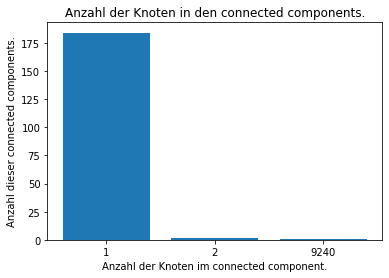

In [64]:
plt.bar(x=['1', '2', '9240'], height=np.unique(anzahl_cc, return_counts=True)[1])
plt.title('Anzahl der Knoten in den connected components.')
plt.xlabel('Anzahl der Knoten im connected component.')
plt.ylabel('Anzahl dieser connected components.')
plt.show()

In [65]:
np.unique(anzahl_cc, return_counts=True)

(array([   1,    2, 9240]), array([184,   2,   1], dtype=int64))

Im deutschen Twitch-Raum hat es 187 connected components. Davon bestehen aber 186 nur aus 1 oder 2 Knoten. Die grösste Anzahl Knoten (184) sind zusammen in einem connected component.

#### Algorithmus
Unser Algorithmus soll die `group_degree_centrality` maximieren mit einer gewissen Anzahl user, damit wir wenig Verträge abschliessen müssen (`MAX_VERTRÄGE`). Ebenfalls sollen diese Gruppe wenig Überlappung haben, damit wir viele verschiedene User beeinflussen können. Wir wollen aber nicht viele Verträge abschliessen, definieren also eine Variable, welche diese begrenzt. 

Somit wollen wir mit einer bestimten Anzahl User die `group_degree_centrality` maximieren.

In [66]:
MAX_VERTRÄGE = 8

In [67]:
def maximize_group_degree_centrality(G, max_users, verbose=True):
    """
    Maximizes group degree centrality of users.
    Parameters:
    -----------
    G: networkx.Graph
        Network.
    max_users: int
        Maximum number of users to be considered.
    Returns:
    --------
    pandas.DataFrame
        Users with the highest group degree centrality.
    """
    if verbose:
        print(f'Copying Graph')
    G = G.copy()

    if verbose:
        print(f'Starting optimization')
    high_degree_centrality_users = []
    # Starting optimization
    for _ in range(max_users):
        degrees = G.degree()
        degrees = pd.DataFrame(degrees, columns=['numeric_id', 'degree'])
        high_degree_user = degrees[degrees.degree == degrees.degree.max()].numeric_id.values[0]
        high_degree_centrality_users.append(high_degree_user)

        # Drop overlap users
        to_drop_users = [high_degree_user]
        to_drop_users.extend([neighbor for neighbor in G.neighbors(high_degree_user)])
        G.remove_nodes_from(to_drop_users)
        if len(G.nodes()) == 0:
            print(f'No more users available')
            return high_degree_centrality_users

    return high_degree_centrality_users

In [68]:
high_degree_centrality_users = maximize_group_degree_centrality(G_de, MAX_VERTRÄGE)

Copying Graph
Starting optimization


In [69]:
print(f'Group Degree Centrality of high degree centrality users: {nx.group_degree_centrality(G_de, high_degree_centrality_users):.2f}')

Group Degree Centrality of high degree centrality users: 0.60


Wir erreichen also 60% der deutschen User mit unseren 8 Leuten.

In [70]:
range_of_max_users = range(3, 1000, 20)

##
group_degree_centralities = []
for max_users in range_of_max_users:
    high_degree_centrality_users = maximize_group_degree_centrality(G_de, max_users, verbose=False)
    group_degree_centralities.append(nx.group_degree_centrality(G_de, high_degree_centrality_users))

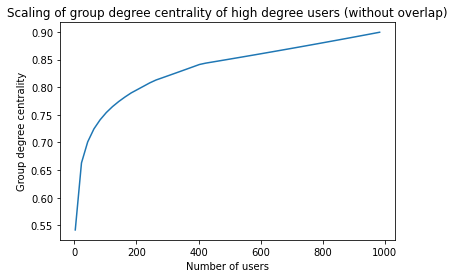

In [71]:
plt.plot(range_of_max_users, group_degree_centralities)
plt.xlabel('Number of users')
plt.ylabel('Group degree centrality')
plt.title('Scaling of group degree centrality of high degree users (without overlap)')
plt.show()

In der oberen Grafik sehen wir, dass unsere nicht-überlappende `group-degree-centrality` von unseren ausgewählten User mit einer grösseren Anzahl von Usern zunimmt. Leider nimmt diese weniger stark zu, desto grösser die Gruppe schon ist. Am Anfang sehen wir eine starke zunahme, bis ca. 100 Usern. Damit nimmt diese stark ab. Diese Abnahme können wir auch genauer anschauen:

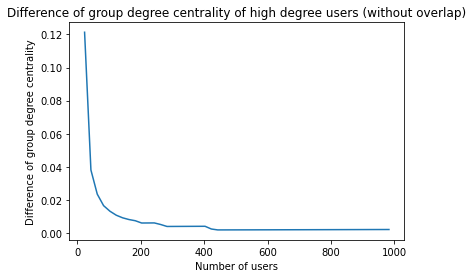

In [72]:
plt.plot(range_of_max_users[1:], np.diff(group_degree_centralities))
plt.xlabel('Number of users')
plt.ylabel('Difference of group degree centrality')
plt.title('Difference of group degree centrality of high degree users (without overlap)')
plt.show()

Wir können durch eine Subtraktion ein theoretisches Optimum herausfinden, basierend auf der stärke Zunahme der `group degree centrality` mit neuen Usern. Natürlich sollten wir uns eher auf eine Reichweite festlegen, aber das gibt schonmal guten Input. Die Abnahme ist beim Unterschreiten von ca. 0.02 der Subtraktion viel schwächer. 

In [73]:
# Extraktion vom index beim unterschreiten des Wertes von 0.02.
optimum_idx = np.argmax(np.diff(group_degree_centralities)<0.02)
optimum_max_users = range_of_max_users[optimum_idx]

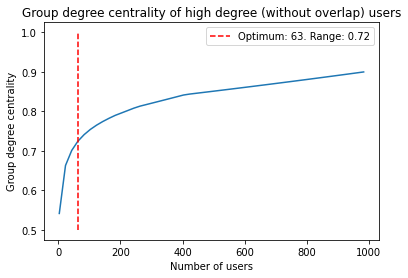

In [74]:
plt.plot(range_of_max_users, group_degree_centralities)
plt.xlabel('Number of users')
plt.ylabel('Group degree centrality')
plt.vlines(x=optimum_max_users, ymin=0.5, ymax=1, linestyles='dashed', colors='red', label=f'Optimum: {optimum_max_users}. Range: {group_degree_centralities[optimum_idx]:.2f}')
plt.legend()
plt.title('Group degree centrality of high degree (without overlap) users')
plt.show()

Somit wäre eine Anzahl von 63 Usern ein guter, effizienter Wert um die Reichweite zu maximieren, welcher 72% vom deutschen Raum erreichen würde.

#### High Impact User
Wer sind diese High Impact User?

In [75]:
high_degree_centrality_users = maximize_group_degree_centrality(G_de, MAX_VERTRÄGE)

Copying Graph
Starting optimization


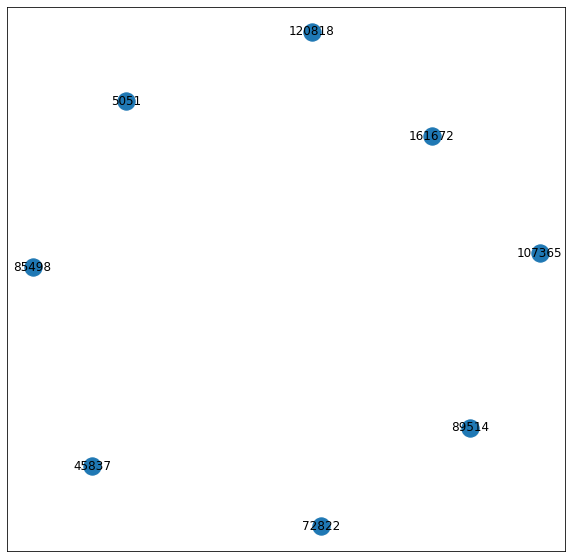

In [76]:
G_hiu = nx.subgraph(G_de, high_degree_centrality_users)
plt.figure(figsize=(10,10))
nx.draw_networkx(G_hiu, with_labels=True)
plt.show()

Die User sind nicht verbunden, da wir ja für weitere `high impact user` die Nachbarn des gewählten Users und den User selbst ausser acht gelassen haben, damit wir keine, grosse Überlappung haben.

In [77]:
user_shortest_path = []
for i, from_user in enumerate(high_degree_centrality_users):
    for to_user in high_degree_centrality_users[i:]:
        user_shortest_path.extend(nx.shortest_path(G_de, from_user, to_user))


In [78]:
G_hiu_spath = nx.subgraph(G_de, np.unique(user_shortest_path))

In [79]:
hiu_drawing_info = pd.DataFrame(list(G_hiu_spath.nodes()), columns=['numeric_id'])
hiu_drawing_info['size'] = np.where(hiu_drawing_info.numeric_id.isin(high_degree_centrality_users), 1000, 300)
hiu_drawing_info['color'] = np.where(hiu_drawing_info.numeric_id.isin(high_degree_centrality_users), 'red', 'blue')

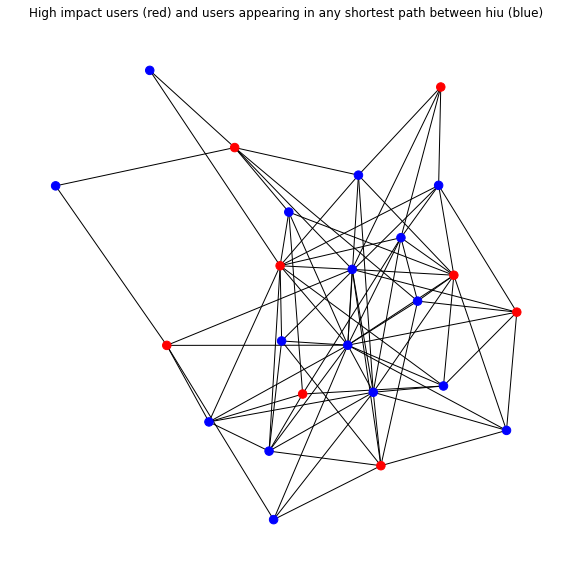

In [80]:
plt.figure(figsize=(10, 10))
ax = plt.gca()
ax = plt.gca()
ax.set_title('High impact users (red) and users appearing in any shortest path between hiu (blue)')
nx.draw(G_hiu_spath, node_size=hiu_drawing_info.size, node_color=hiu_drawing_info.color, with_labels=False, font_size=10)
plt.show()

Rot sind unsere `high impact user` und blaue user, welche in irgendeiner kürzesten Distanz zwischen zwei `high impact usern` vorkommen.

In [81]:
user_shortest_path = []
for i, from_user in enumerate(high_degree_centrality_users):
    for to_user in high_degree_centrality_users[i:]:
        user_shortest_path.append(nx.shortest_path_length(G_de, from_user, to_user))

print(f'Durchschnittliche Distanz zwischen den high impact user: {np.mean(user_shortest_path):.2f}')

Durchschnittliche Distanz zwischen den high impact user: 1.56


Wir sehen also, dass im Durchschnitt zwischen zwei (shortest path) `high impact user` 1.56 Nodes sind. Es ist interessant, wie nahe diese hiu zueinander sind. Haben wir da eine `clique` gefunden? 

## Clique Detection
### Clique Detection mit Louvain's Algorithmus


In [82]:
import networkx as nx
import networkx.algorithms.community as nx_comm
de_communities_louvain = nx_comm.louvain_communities(G_de, seed=42)

In [83]:
size_of_communities = [len(x) for x in de_communities_louvain]

In [84]:
np.unique(size_of_communities, return_counts=True)

(array([   1,    2,  221,  689,  870, 1079, 1234, 1392, 1776, 1979]),
 array([184,   2,   1,   1,   1,   1,   1,   1,   1,   1], dtype=int64))

Die obere Zeile entspricht der Grösse der Community (Anzahl User per Community) und die untere der Anzahl der Communities mit dieser Grösse.
Wir sehen beim oberen Output, dass wir hier wieder die 184 nicht-verbundenen Subgraphen sehen, welche nur aus sich selbst bestehen. Diese bilden dann logischerweise nur alleine eine Community. Wir können schauen, ob unsere vorhin gefundene Gruppe von Usern mit einer hohen `group degree centrality`, zusammen in einer Community auftauchen.

In [175]:
hiu_communities = {}
nr_hiu_in_community = []
for community_id, community in enumerate(de_communities_louvain):
    if len(community) > 1:
        hius_in_community = np.intersect1d(high_degree_centrality_users, list(community))
        if len(hius_in_community) > 0:
            dict_ = {'nr_hius': len(hius_in_community), 'users': community, 'hius': hius_in_community, 'sub_graph': nx.subgraph(G_de, community)}
            hiu_communities[community_id] = dict_

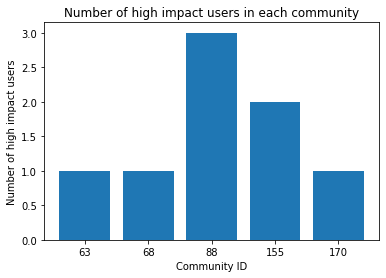

In [171]:
plt.bar(x=[str(x) for x in hiu_communities.keys()], height=[x[1]['nr_hius'] for x in hiu_communities.items()])
plt.xlabel('Community ID')
plt.ylabel('Number of high impact users')
plt.title('Number of high impact users in each community')
plt.show()

Wir sehen, dass unsere `hiu`s in unterschiedlichen Communities sind. 3 davon sind aber in der grössten Community.

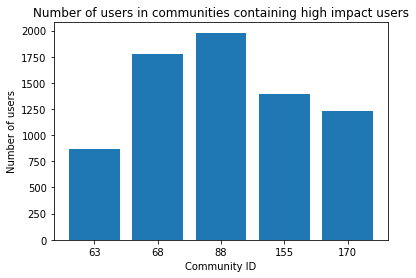

In [255]:
plt.bar(x=[str(x) for x in hiu_communities.keys()], height=[len(de_communities_louvain[x]) for x in hiu_communities.keys()])
plt.xlabel('Community ID')
plt.ylabel('Number of users')
plt.title('Number of users in communities containing high impact users')
plt.show()

Im oberen Plot sehen wir die unterschiedlichen Grössen der Communities.

In [257]:
def plot_extract_community_graph(G, community_id, hiu_users, pos_algo, min_degree = 3):
    to_remove = [node for node,degree in dict(G.degree()).items() if degree < min_degree]

    G_c = G.copy()
    G_c.remove_nodes_from(to_remove)

    community_graph = nx.subgraph(G_c, hiu_communities[community_id]['users'])
    drawing_info = pd.DataFrame(list(community_graph.nodes()), columns=['numeric_id'])
    drawing_info['size'] = np.where(drawing_info.numeric_id.isin(hiu_users), 3, 1)
    drawing_info['color'] = np.where(drawing_info.numeric_id.isin(hiu_users), 'red', 'blue')
    drawing_info['alpha'] = np.where(drawing_info.numeric_id.isin(hiu_users), 1, 0.01)

    plt.figure(figsize=(8, 8))
    ax = plt.gca()
    ax = plt.gca()
    ax.set_title(f'Community {community_id}. Hius are in red and users in the community are blue')
    pos = pos_algo(community_graph)
    nx.draw(community_graph, pos=pos, node_size=drawing_info.size, node_color=drawing_info.color, with_labels=False, alpha=drawing_info.alpha)
    plt.show()

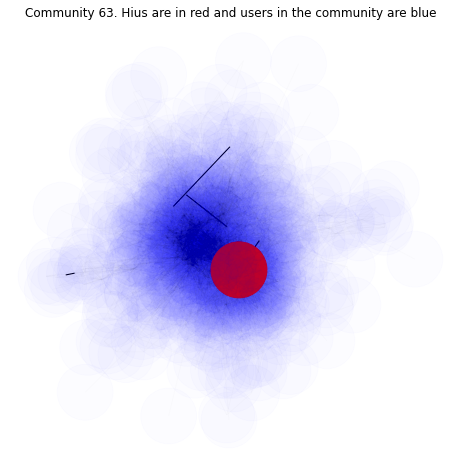

In [258]:
COMMUNITY_ID_TO_PLOT = 63
plot_extract_community_graph(G_de, COMMUNITY_ID_TO_PLOT, hiu_communities[COMMUNITY_ID_TO_PLOT]['hius'], nx.spring_layout)

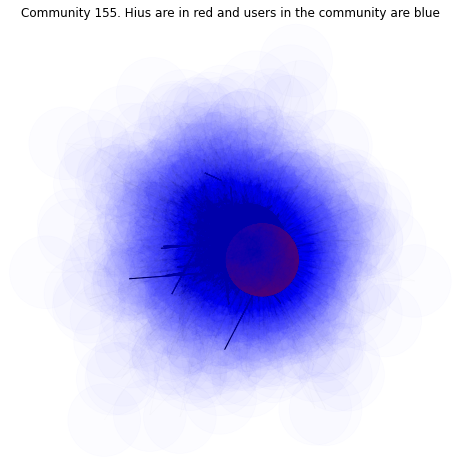

In [259]:
COMMUNITY_ID_TO_PLOT = 155
plot_extract_community_graph(G_de, COMMUNITY_ID_TO_PLOT, hiu_communities[COMMUNITY_ID_TO_PLOT]['hius'], nx.spring_layout)

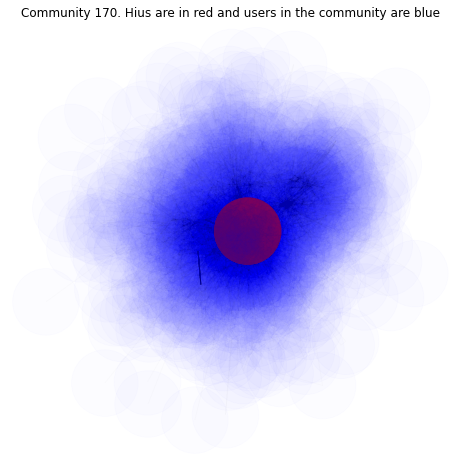

In [260]:
COMMUNITY_ID_TO_PLOT = 170
plot_extract_community_graph(G_de, COMMUNITY_ID_TO_PLOT, hiu_communities[COMMUNITY_ID_TO_PLOT]['hius'], nx.spring_layout)

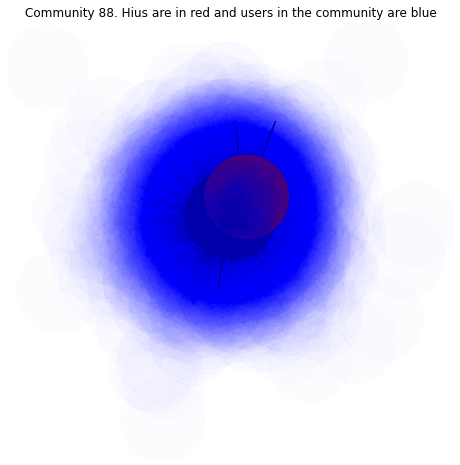

In [261]:
COMMUNITY_ID_TO_PLOT = 88
plot_extract_community_graph(G_de, COMMUNITY_ID_TO_PLOT, hiu_communities[COMMUNITY_ID_TO_PLOT]['hius'], nx.spring_layout)

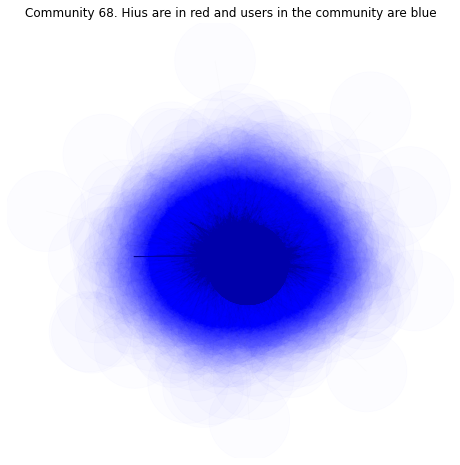

In [263]:
COMMUNITY_ID_TO_PLOT = 68
plot_extract_community_graph(G_de, COMMUNITY_ID_TO_PLOT, hiu_communities[COMMUNITY_ID_TO_PLOT]['hius'], nx.spring_layout)

Wir sehen, dass allen Communities in der Mitte sind, wenn wir den Graphen mit dem `spring-layout` plotten. Sie sind also `physikalisch` immer in der Mitte des geschehens.

In [201]:
rank_in_community = []
for community_id in hiu_communities.keys():
    community_dict = hiu_communities[community_id]
    community_df = pd.DataFrame(hiu_communities[community_id]['sub_graph'].degree, columns=['numeric_id', 'degree']).sort_values('degree', ascending=False).reset_index(drop=True)
    community_df_hiu = community_df[community_df.numeric_id.isin(community_dict['hius'])]
    rank_in_community.append(min(community_df_hiu.index.values)+1)

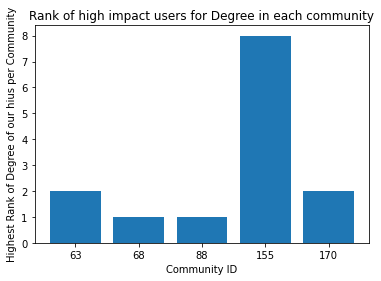

In [241]:
plt.bar(x=[str(x) for x in hiu_communities.keys()], height=rank_in_community)
plt.xlabel('Community ID')
plt.ylabel('Highest Rank of Degree of our hius per Community')
plt.title('Rank of high impact users for Degree in each community')
plt.show()

Wir sehen im oberen Plot pro Community den besten, erreichten Rang von irgendeinem unserer `hiu` per Community. Wie erwartet erreichen unsere `hiu`s in jeder Community einen hohen Degree-Stellenwert. Interessant ist aber, dass wir in der Community 155 nur den 8ten Platz erreichen. Hier wäre es interessant zu suchen, warum dies der Fall ist. 

Wie sieht es aber mit der `betweenness-cetrality` aus?

In [238]:
betweenness_centralities = {}
rank_in_community_bc = []
for community_id in hiu_communities.keys():
    betweenness_centralities[community_id] = nx.betweenness_centrality(hiu_communities[community_id]['sub_graph'])
    bc_df = pd.DataFrame.from_dict(betweenness_centralities[community_id], columns=[ 'betweenness centrality'], orient='index').sort_values('betweenness centrality', ascending=False).reset_index()
    bc_df['numeric_id'] = bc_df['index'].copy()
    bc_df = bc_df.drop(columns=['index'])
    bc_hiu_df = bc_df[bc_df.numeric_id.isin(hiu_communities[community_id]['hius'])]
    rank_in_community_bc.append(min(bc_hiu_df.index.values)+1)

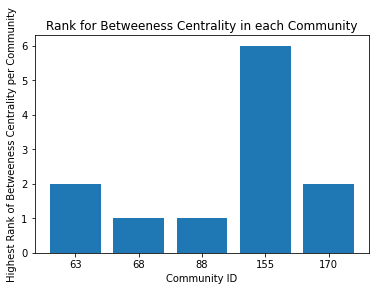

In [246]:
plt.bar(x=[str(x) for x in hiu_communities.keys()], height=rank_in_community_bc)
plt.xlabel('Community ID')
plt.ylabel('Highest Rank of Betweeness Centrality per Community')
plt.title('Rank for Betweeness Centrality in each Community')
plt.show()

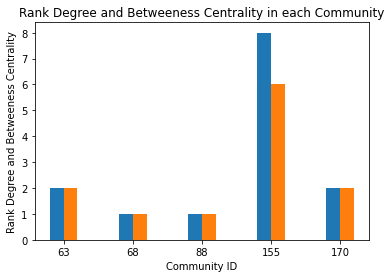

In [253]:
x = np.arange(1, len(rank_in_community_bc)+1)
plt.bar(x=x - 0.1, height=rank_in_community, width=0.2)
plt.bar(x=x + 0.1, height=rank_in_community_bc, width=0.2)
plt.xticks(x, [str(x) for x in hiu_communities.keys()])
plt.xlabel('Community ID')
plt.ylabel('Rank Degree and Betweeness Centrality')
plt.title('Rank Degree and Betweeness Centrality in each Community')
plt.show()

Unsere `hiu`s erreichen auch bei der `betweenness-centrality` einen hohen Rang. Es ist aber wieder die Community `155` als Ausreisser dabei. 

## Ausblick
Unsere Analysen lassen sich auch auf den englischen Raum übertragen. Wir könnten also auch weitere Märkte sehr gut ins Auge fassen. Falls wir uns auf Twitch fokusieren würden, könnten wir damit anfangen, die Daten zeitlich zu erfassen Dies beduetet, z.B. wöchentlich einen digitalen Abdruck von Twitch als Sociales Netwerk abspeichern. Damit liesse sich noch besser `hiu`s finden, man könnte Aufsteiger abfangen und als günstigen Influencer anwerben, falls man den Algorithmus `maximize_views_per_year_per_degree_without_overlap` auf die Views von den z.B. vergangenen 4 Wochen beeinschränken würde. Damit liessen sich Aufsteiger entdecken, welche aber noch nicht so etabliert sind.

Eine weitere Idee wäre das verbreiten von Informationen. Wir könnten uns auch anschauen, wie Podcast-Streamer informationen verbreiten, z.B. mit einem `Independent-Cascade-Model`. Wir könnten da als `p` die Aktivität des Podcasters nehmen (#StundenStreamingProWoche / #StundenInDerWoche) und so Podcaster finden, welche unsere Informationen verbreiten könnten.

Es gab letztens auch einen [Leak über die Twitch-Payouts](https://dotesports.com/streaming/news/full-list-of-all-twitch-payouts-twitch-leaks). Das wäre natürlich ein sehr interessantes, neues Features und man könnte damit die `Degrees` aus dem Algorithmus `maximize_views_per_year_per_degree_without_overlap` ersetzen, damit die Ausgangslage mehr der Realität entspricht, da die `Degrees` wohl nicht perfekt mit den Einnahmen von Streamer übereinstimmen.